The model training has been completed, below stats describe the training process - Softmax model in red, EDL model in blue:

![training stats](../data/images/training_stats.JPG)

It is evident the EDL model training faced a 'hurdle' up until ~4k steps into the training (see the `train/accuracy` and `train/loss` graphs), where accuracy reached levels described in the paper. It might be related to the training warmup phase implemented in the model described in the paper that was not part of this implementation. Either way, the model is ready for evaluation and experiments, so let's get to it!

In the below analysis we will experiment with the Softmax and EDL models, specifically:
* test behaviour of the models when the input image is rotated
* test edl model uncertainty given out of sample, unusual inputs

## Imports

In [7]:
%load_ext autoreload
%autoreload 2

from typing import  Tuple
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from torch import Tensor
from torchvision.transforms.functional import rotate

from pytorch_lightning import LightningModule

from dataset.mnist_data_module import MNISTDataModule
from model.lenet_softmax import LeNetSoftmax
from model.lenet_edl import LeNetEDL
from utilities import image_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's import the champion models for further analysis:

In [8]:
sm_checkpoint_path = '../output/LeNetEDL-relu-mse-epoch=18-validation/accuracy=0.983.ckpt'
sm_model = LeNetSoftmax.load_from_checkpoint(sm_checkpoint_path)


edl_checkpoint_path = '../output/LeNetEDL-relu-mse-epoch=18-validation/accuracy=0.983.ckpt'
edl_model = LeNetEDL.load_from_checkpoint(edl_checkpoint_path)

In [9]:
data_module = MNISTDataModule()
train_dataloader = data_module.train_dataloader()
data_batch = next(iter(train_dataloader))

In [10]:
def compare_model_results(
        data_batch: Tuple[Tensor, Tensor], 
        num_img: int, 
        rotate_angle: float, 
        sm_model: LeNetSoftmax, 
        edl_model: LeNetEDL
    ) -> None:
    """
    Compares model results for rotated images
    """
    batch_tensor_image = data_batch[0][num_img:num_img+1]
    label = data_batch[1][num_img:num_img+1]
    print('='*60)
    print('Expected label:', int(label))
    print(f'Rotation angle: {rotate_angle}')

    rotated_image = rotate(batch_tensor_image, rotate_angle)
    show_model_results(rotated_image, sm_model, edl_model)


def show_model_results(image: Tensor, sm_model: LeNetSoftmax, edl_model: LeNetEDL) -> None:
    """
    Shows comparison of model results on a given image tensor
    """
    image_utils.show_tensor_image(image[0])
    plt.show()
    print('-'*60)
    print('SOFTMAX:')
    print_model_results(sm_model, image)
    print('-'*60)
    print('EDL:')
    print_model_results(edl_model, image)
    print()

def print_model_results(model: LightningModule, image: Tensor):
    """
    Displays the model results
    """
    predicted_classes, predicted_probabilities, uncertainty = model.predict(image)
    predicted_class = int(predicted_classes[0])
    predicted_probability = float(predicted_probabilities[0][predicted_class])
    print(f'Predicted class: {predicted_class} (probability={predicted_probability:.1%})')
    if uncertainty:
        uncertainty_val = float(uncertainty[0][0])
        print(f'Epistemic uncertainty: {uncertainty_val:.1%}')


### Vulnerability to image rotation

Expected label: 7
Rotation angle: 6


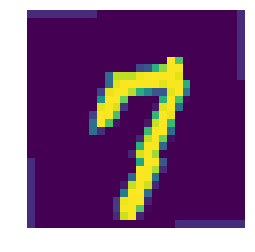

------------------------------------------------------------
SOFTMAX:
Predicted class: 7 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 7 (probability=92.8%)
Epistemic uncertainty: 8.0%

Expected label: 1
Rotation angle: 54


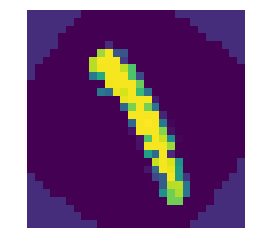

------------------------------------------------------------
SOFTMAX:
Predicted class: 1 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 1 (probability=76.8%)
Epistemic uncertainty: 25.7%

Expected label: 0
Rotation angle: 241


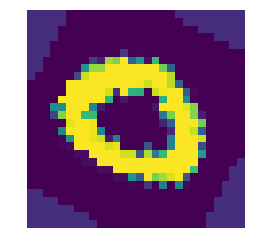

------------------------------------------------------------
SOFTMAX:
Predicted class: 0 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 0 (probability=56.4%)
Epistemic uncertainty: 6.7%

Expected label: 0
Rotation angle: 289


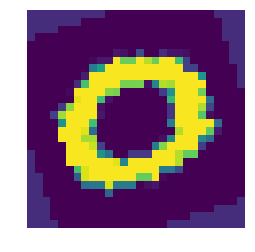

------------------------------------------------------------
SOFTMAX:
Predicted class: 0 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 0 (probability=96.3%)
Epistemic uncertainty: 4.1%

Expected label: 0
Rotation angle: 109


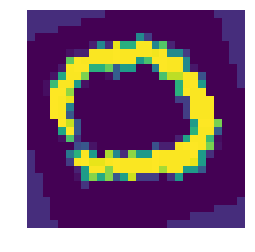

------------------------------------------------------------
SOFTMAX:
Predicted class: 0 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 0 (probability=76.4%)
Epistemic uncertainty: 6.7%



In [11]:
for _ in range(5):
    num_img = np.random.randint(0, 63)
    rotate_angle = np.random.randint(0,359)
    compare_model_results(data_batch, num_img, rotate_angle, sm_model, edl_model)

The above model comparison shows exactly why understanding epistemic uncertainty is important: for even highly rotated images, the Softmax model predicts results with near 100% probability. Measuring the uncertainty of the EDL model we can get a sense where the model is not sure of its predictions. 

### Vulnerability to unusual out-of-sample images 

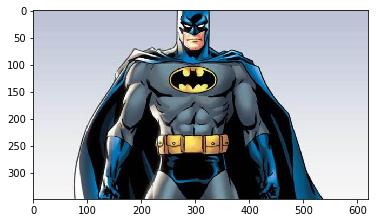

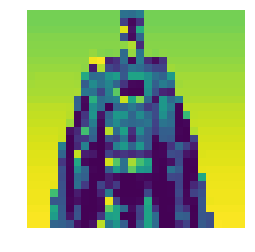

------------------------------------------------------------
SOFTMAX:
Predicted class: 9 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 9 (probability=48.7%)
Epistemic uncertainty: 0.1%



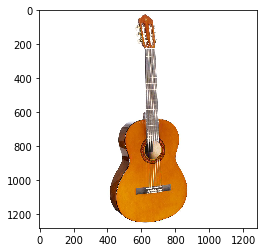

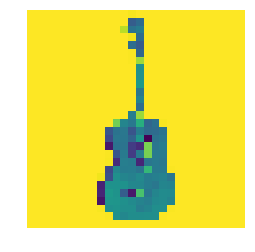

------------------------------------------------------------
SOFTMAX:
Predicted class: 6 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 6 (probability=69.1%)
Epistemic uncertainty: 0.2%



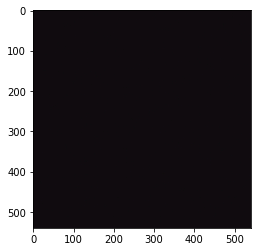

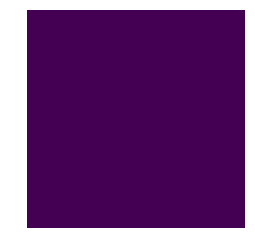

------------------------------------------------------------
SOFTMAX:
Predicted class: 8 (probability=34.1%)
------------------------------------------------------------
EDL:
Predicted class: 8 (probability=19.0%)
Epistemic uncertainty: 86.2%



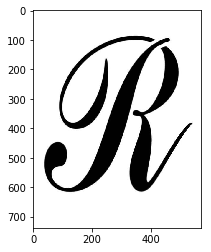

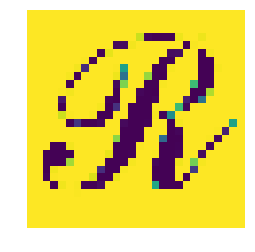

------------------------------------------------------------
SOFTMAX:
Predicted class: 8 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 8 (probability=99.3%)
Epistemic uncertainty: 0.7%



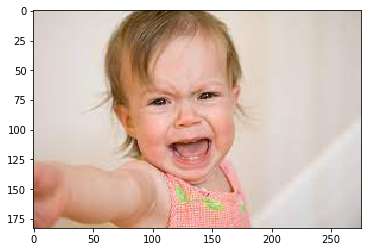

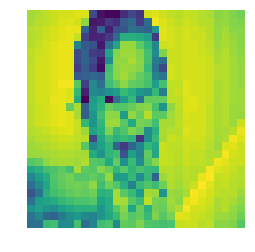

------------------------------------------------------------
SOFTMAX:
Predicted class: 8 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 8 (probability=67.1%)
Epistemic uncertainty: 0.2%



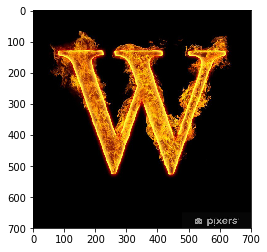

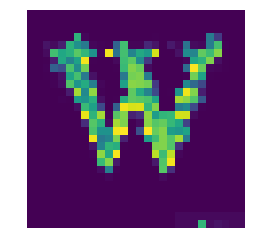

------------------------------------------------------------
SOFTMAX:
Predicted class: 6 (probability=100.0%)
------------------------------------------------------------
EDL:
Predicted class: 6 (probability=61.0%)
Epistemic uncertainty: 2.7%



In [12]:
out_of_sample_image_path = Path('../data/images/out_of_sample')

for image_path in out_of_sample_image_path.iterdir():
    print('='*60)
    image = image_utils.read_image(image_path)
    plt.show()
    image_tensor = image_utils.convert_to_model_input(image)
    show_model_results(image_tensor, sm_model, edl_model)

Comparison of the models on unusual out-of-sample images further proves that the EDL model is far more 'realistic' about the predictions it is making. While the uncertainty measure itself is not as high as we would expect in all cases, the predicted probability for the unusual images is in most cases significantly below the Softmax predictions.